In [1]:
!git clone https://github.com/Felinchen76/bio-pinn.git
%cd bio-pinn

Cloning into 'bio-pinn'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 73 (delta 22), reused 63 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (73/73), 1.33 MiB | 11.05 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/workspaces/bio-pinn/Felicitas/bio-pinn


In [2]:
# Ordner zu ZIP packen
!zip -r bio-pinn-Data.zip "/content/bio-pinn/Data"

# ZIP herunterladen (landet im lokalen Downloads-Ordner)
from google.colab import files
files.download("bio-pinn-Data.zip")

	zip warning: name not matched: /content/bio-pinn/Data

zip error: Nothing to do! (try: zip -r bio-pinn-Data.zip . -i /content/bio-pinn/Data)


ModuleNotFoundError: No module named 'google'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())

/content


# Analyze Data

Gefundene Dateien:
 - exp1_4W.csv
 - exp1_5W.csv
 - exp1_6W.csv
 - exp2_4W.csv
 - exp2_5W.csv
 - exp2_6W.csv
 - exp3_4W.csv
 - exp3_5W.csv
 - exp3_6W.csv

Überblick (erste Zeilen):


,t,TG,DG,MG,G,ME,exp_id,power_W,source_file,Glyc_sum,Total_sum,Total_sum_norm
0,0,0.619114,0.040005,0.000395,NaN,NaN,1,4,exp1_4W.csv,0.659514,0.659514,1.000000
1,60,0.298578,0.277327,0.172872,NaN,NaN,1,4,exp1_4W.csv,0.748776,0.748776,1.135346
2,120,0.060526,0.076128,0.062899,NaN,NaN,1,4,exp1_4W.csv,0.199553,0.199553,0.302576
3,240,0.050199,0.065211,0.058818,NaN,NaN,1,4,exp1_4W.csv,0.174228,0.174228,0.264176
4,360,0.033788,0.039725,0.037633,NaN,NaN,1,4,exp1_4W.csv,0.111146,0.111146,0.168528
5,600,0.022332,0.025764,0.027812,0.596782,1.790345,1,4,exp1_4W.csv,0.075909,2.463036,3.734624
15,0,0.619114,0.040005,0.000395,NaN,NaN,2,4,exp2_4W.csv,0.659514,0.659514,1.000000
16,60,0.183993,0.166317,0.120384,NaN,NaN,2,4,exp2_4W.csv,0.470694,0.470694,0.713698
17,120,0.110043,0.125132,0.105132,NaN,NaN,2,4,exp2_4W.csv,0.340307,0.340307,0.515997
18,240,0.056924,0.063662,0.058683,NaN,NaN,2,4,exp2_4W.csv,0.179269,0.179269,0.271820



Fehlende Werte je Spalte:


,0
t,0
TG,0
DG,0
MG,0
G,42
ME,42



Basis-Statistik:


,t,TG,DG,MG,G,ME
count,45.000000,45.000000,45.000000,45.000000,3.000000,3.000000
mean,172.000000,0.190437,0.082416,0.061639,0.598379,1.795137
std,165.606324,0.224665,0.061215,0.048635,0.001658,0.004974
min,0.000000,0.019023,0.021643,0.000395,0.596782,1.790345
25%,60.000000,0.042514,0.040005,0.027812,0.597523,1.792568
50%,120.000000,0.070834,0.063662,0.058818,0.598264,1.794791
75%,240.000000,0.183993,0.106960,0.093389,0.599178,1.797533
max,600.000000,0.619114,0.277327,0.172872,0.600092,1.800275



Kombinierte Daten gespeichert unter: /content/bio-pinn/Data/combined_exp.csv


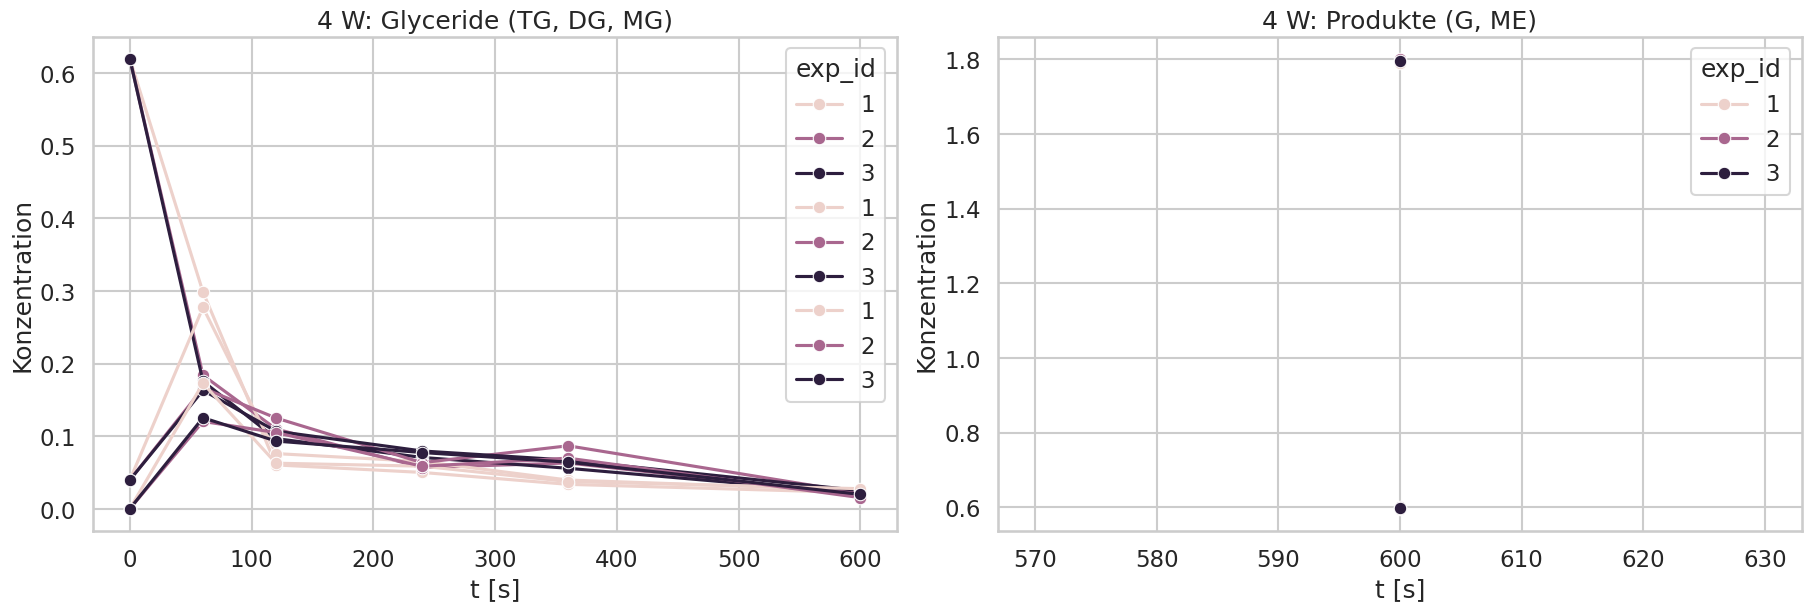

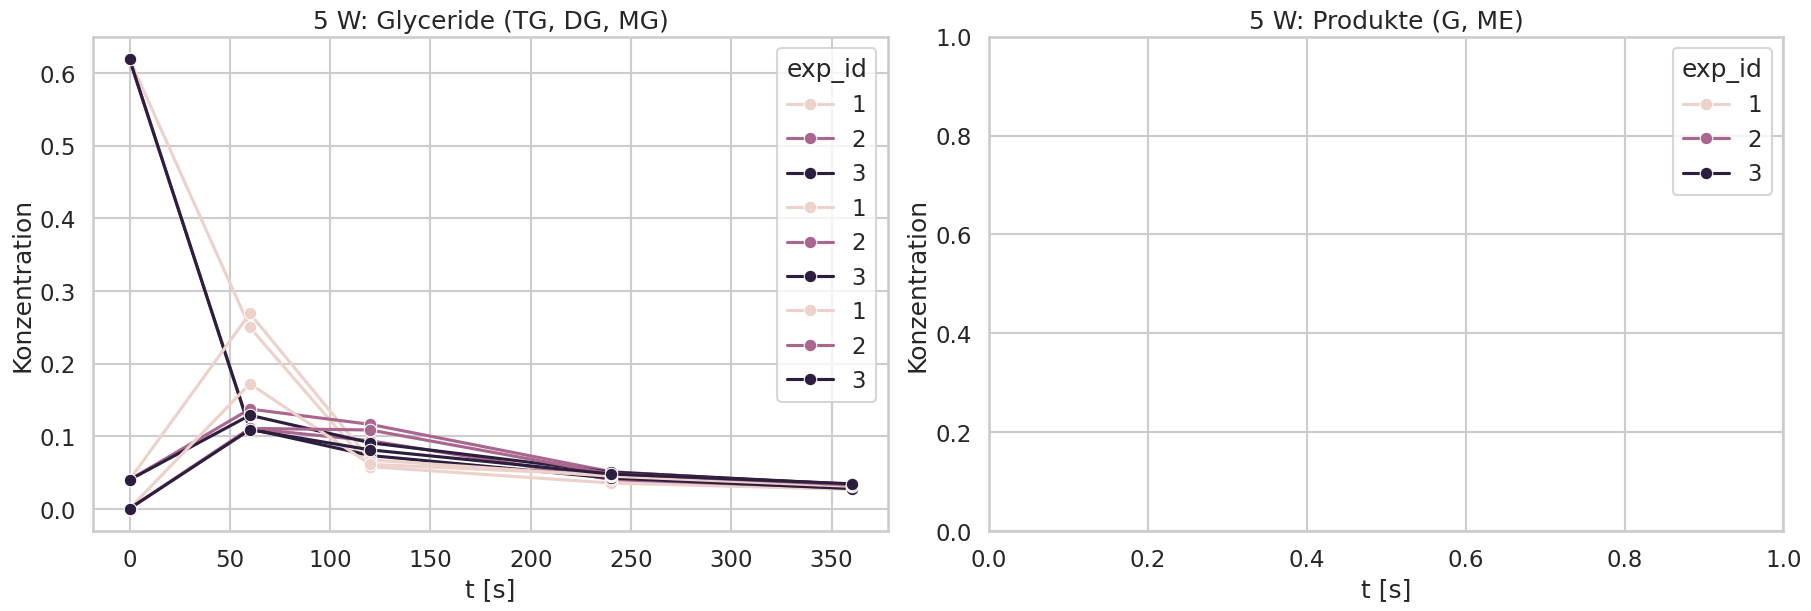

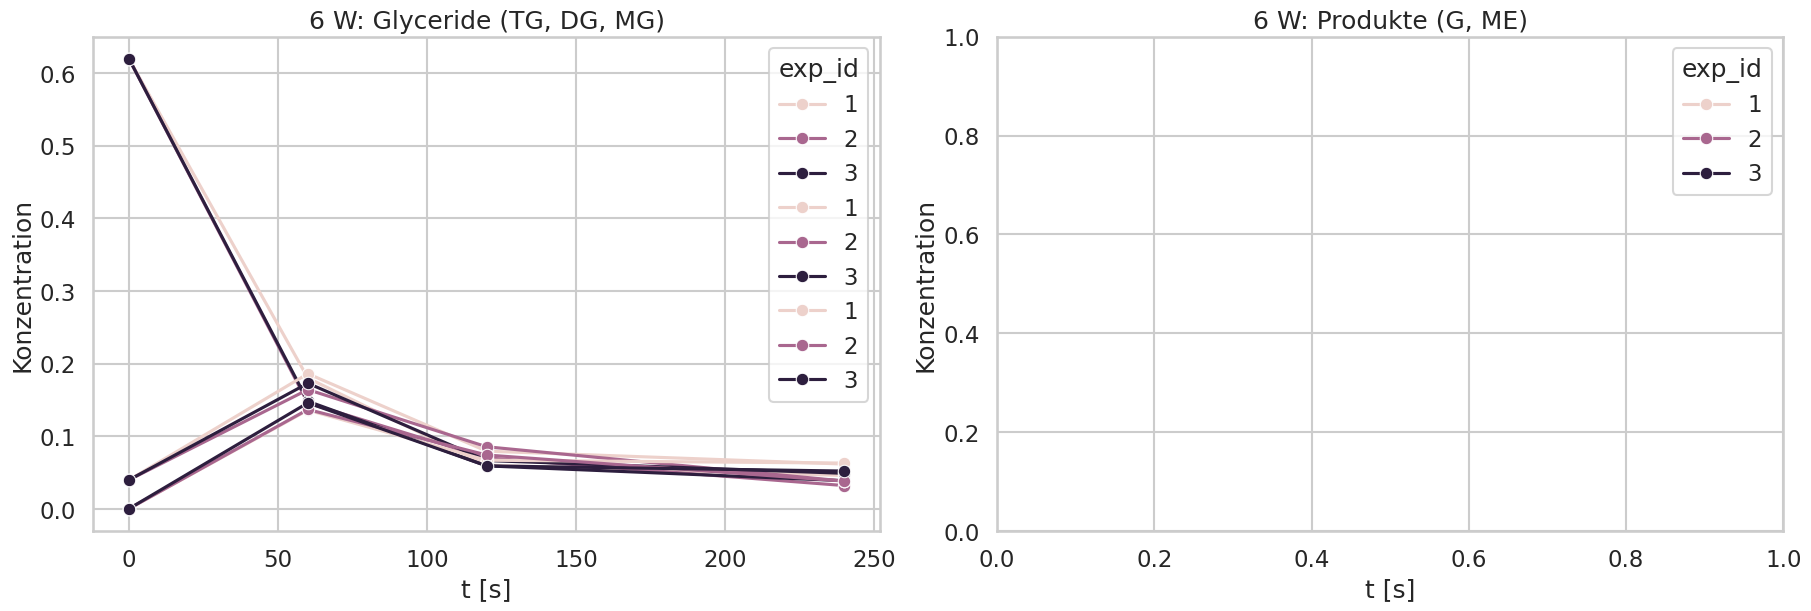

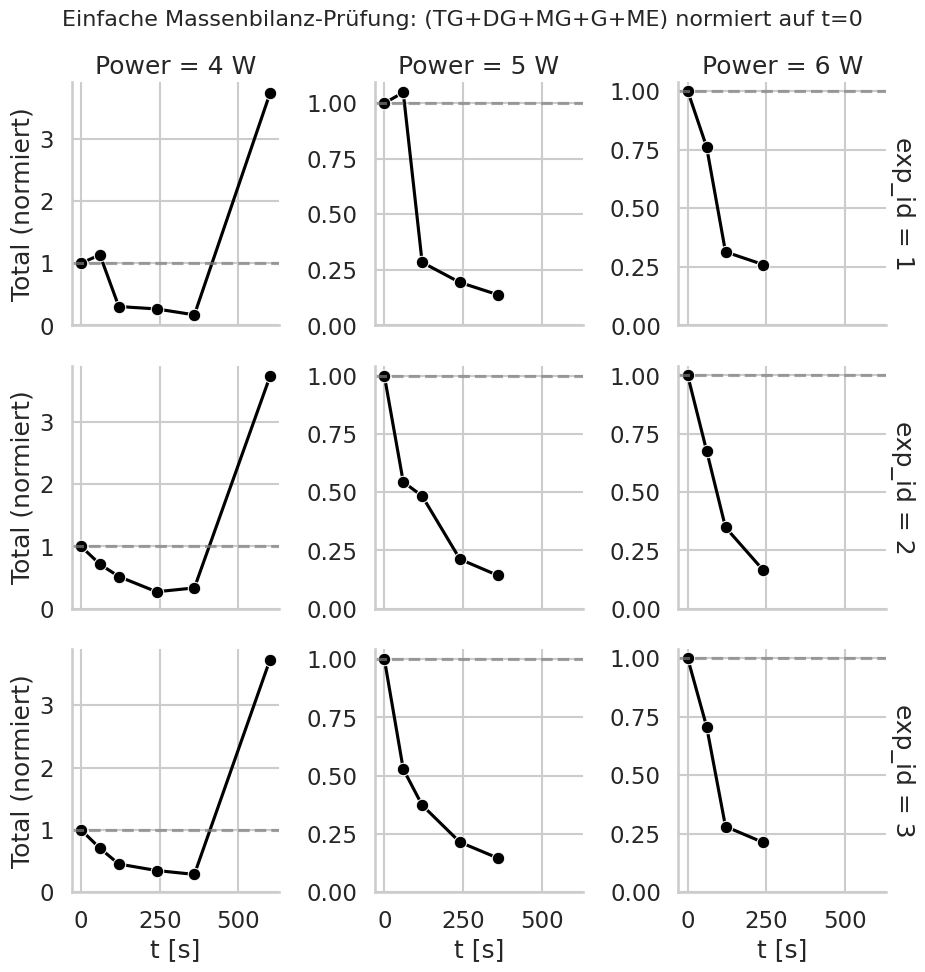


Long-Format Vorschau:


,t,exp_id,power_W,source_file,species,concentration
45,0,1,4,exp1_4W.csv,DG,0.040005
46,60,1,4,exp1_4W.csv,DG,0.277327
47,120,1,4,exp1_4W.csv,DG,0.076128
48,240,1,4,exp1_4W.csv,DG,0.065211
49,360,1,4,exp1_4W.csv,DG,0.039725
50,600,1,4,exp1_4W.csv,DG,0.025764
135,0,1,4,exp1_4W.csv,G,NaN
136,60,1,4,exp1_4W.csv,G,NaN
137,120,1,4,exp1_4W.csv,G,NaN
138,240,1,4,exp1_4W.csv,G,NaN


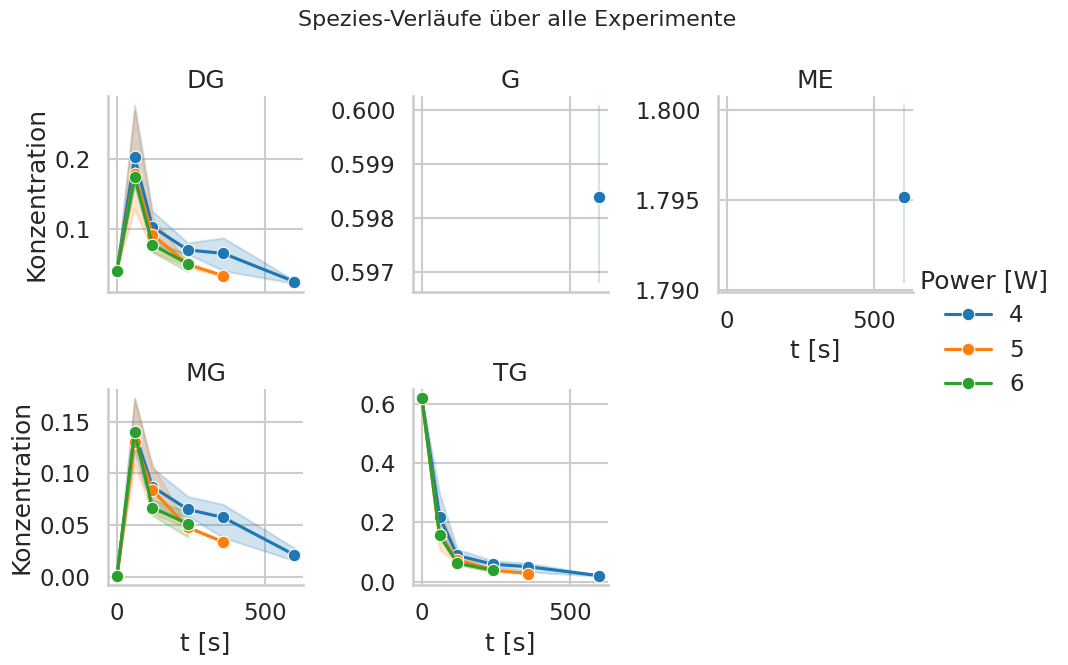

In [ ]:
# analyse data -> /content/bio-pinn/Data
# - Bereitet die Daten auf (NaNs, Typen, Zusatzspalten)
# - Visualisiert:
#   * Konzentrationsverläufe (TG, DG, MG, G, ME) pro Experiment/Leistung
#   * Einfache Massenbilanzprüfung: (TG+DG+MG+G+ME)/Startwert

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

BASE = Path("/content/bio-pinn/Data")
assert BASE.exists(), f"Pfad nicht gefunden: {BASE}"

# columns
expected_cols = ["t", "TG", "DG", "MG", "G", "ME"]
species_cols = ["TG", "DG", "MG", "G", "ME"]

# find all experiment csvs
csv_files = sorted(BASE.glob("exp*_*.csv"))
if not csv_files:
    raise FileNotFoundError("Keine Dateien exp*_*.csv in /content/bio-pinn/Data gefunden.")

print("Gefundene Dateien:")
for f in csv_files:
    print(" -", f.name)

def _coerce_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

frames = []
pattern = re.compile(r"exp(?P<exp>\d+)_(?P<power>\d+)W", re.IGNORECASE)

for path in csv_files:
    # read, empty cells as NaN
    df = pd.read_csv(path, na_values=["", " ", "NA", "NaN"])
    df.columns = [c.strip() for c in df.columns]
    # make sure every column is there
    for c in expected_cols:
        if c not in df.columns:
            df[c] = np.nan
    df = df[expected_cols]
    df = _coerce_numeric(df, expected_cols)

    # meta data
    m = pattern.search(path.stem)
    exp_id = int(m.group("exp")) if m else None
    power_w = int(m.group("power")) if m else None

    df["exp_id"] = exp_id
    df["power_W"] = power_w
    df["source_file"] = path.name

    # Glyceride-sum und and overall value
    df["Glyc_sum"] = df[["TG", "DG", "MG"]].sum(axis=1, skipna=True)
    df["Total_sum"] = df[["TG", "DG", "MG", "G", "ME"]].sum(axis=1, skipna=True)

    # normalized over all value at first time stamp
    if not df["Total_sum"].dropna().empty:
        first_total = df["Total_sum"].dropna().iloc[0]
        df["Total_sum_norm"] = df["Total_sum"] / (first_total if first_total != 0 else np.nan)
    else:
        df["Total_sum_norm"] = np.nan

    frames.append(df)

data = pd.concat(frames, ignore_index=True).sort_values(["power_W", "exp_id", "t"])

# overview
print("\nÜberblick (erste Zeilen):")
display(data.head(10))

print("\nFehlende Werte je Spalte:")
display(data[expected_cols].isna().sum())

print("\nBasis-Statistik:")
display(data[expected_cols].describe())

# save combined data
out_path = BASE / "combined_exp.csv"
data.to_csv(out_path, index=False)
print(f"\nKombinierte Daten gespeichert unter: {out_path}")

# plots: Konzentrationsverläufe je Leistung und Experiment
def plot_species_by_power(data):
    for power, d_power in data.groupby("power_W"):
        fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)
        ax_left, ax_right = axes

        # left: TG, DG, MG
        for s in ["TG", "DG", "MG"]:
            sns.lineplot(
                data=d_power, x="t", y=s, hue="exp_id", marker="o", ax=ax_left, legend=True
            )
        ax_left.set_title(f"{power} W: Glyceride (TG, DG, MG)")
        ax_left.set_xlabel("t [s]")
        ax_left.set_ylabel("Konzentration")
        ax_left.legend(title="exp_id")

        # right: G, ME
        sns.lineplot(
            data=d_power, x="t", y="G", hue="exp_id", marker="o", ax=ax_right, legend=True
        )
        sns.lineplot(
            data=d_power, x="t", y="ME", hue="exp_id", marker="o", ax=ax_right, legend=False
        )
        ax_right.set_title(f"{power} W: Produkte (G, ME)")
        ax_right.set_xlabel("t [s]")
        ax_right.set_ylabel("Konzentration")
        handles, labels = ax_right.get_legend_handles_labels()
        ax_right.legend(handles[: len(set(d_power['exp_id']))], labels[: len(set(d_power['exp_id']))], title="exp_id")

        plt.show()

plot_species_by_power(data)

# normalized over time
def plot_mass_balance(data):
    g = sns.FacetGrid(
        data,
        col="power_W",
        row="exp_id",
        margin_titles=True,
        sharey=False,
        height=3.2
    )
    g.map_dataframe(sns.lineplot, x="t", y="Total_sum_norm", marker="o", color="black")
    g.set_axis_labels("t [s]", "Total (normiert)")
    g.set_titles(row_template="exp_id = {row_name}", col_template="Power = {col_name} W")
    for ax in g.axes.flatten():
        ax.axhline(1.0, ls="--", color="tab:gray", alpha=0.7)
        ax.set_ylim(0, None)
    plt.suptitle("Einfache Massenbilanz-Prüfung: (TG+DG+MG+G+ME) normiert auf t=0", y=1.02, fontsize=16)
    plt.show()

plot_mass_balance(data)

# fast comparison, hence long used
long = data.melt(
    id_vars=["t", "exp_id", "power_W", "source_file"],
    value_vars=species_cols,
    var_name="species",
    value_name="concentration"
).sort_values(["power_W", "exp_id", "species", "t"])

print("\nLong-Format Vorschau:")
display(long.head(10))

# species
g = sns.FacetGrid(long, col="species", hue="power_W", sharey=False, height=3.2, col_wrap=3, palette="tab10")
g.map_dataframe(sns.lineplot, x="t", y="concentration", marker="o")
g.add_legend(title="Power [W]")
g.set_axis_labels("t [s]", "Konzentration")
g.set_titles("{col_name}")
plt.suptitle("Spezies-Verläufe über alle Experimente", y=1.05, fontsize=16)
plt.show()

# ODE

Loaded experiments:
 - exp1_4W.csv (n=6 points, columns present: TG, DG, MG, G, ME)
 - exp1_5W.csv (n=5 points, columns present: TG, DG, MG)
 - exp1_6W.csv (n=4 points, columns present: TG, DG, MG)
 - exp2_4W.csv (n=6 points, columns present: TG, DG, MG, G, ME)
 - exp2_5W.csv (n=5 points, columns present: TG, DG, MG)
 - exp2_6W.csv (n=4 points, columns present: TG, DG, MG)
 - exp3_4W.csv (n=6 points, columns present: TG, DG, MG, G, ME)
 - exp3_5W.csv (n=5 points, columns present: TG, DG, MG)
 - exp3_6W.csv (n=4 points, columns present: TG, DG, MG)


/tmp/ipython-input-530043805.py:126: RuntimeWarning: All-NaN slice encountered
  max_per_species = np.nanmax(exp.Y, axis=1)


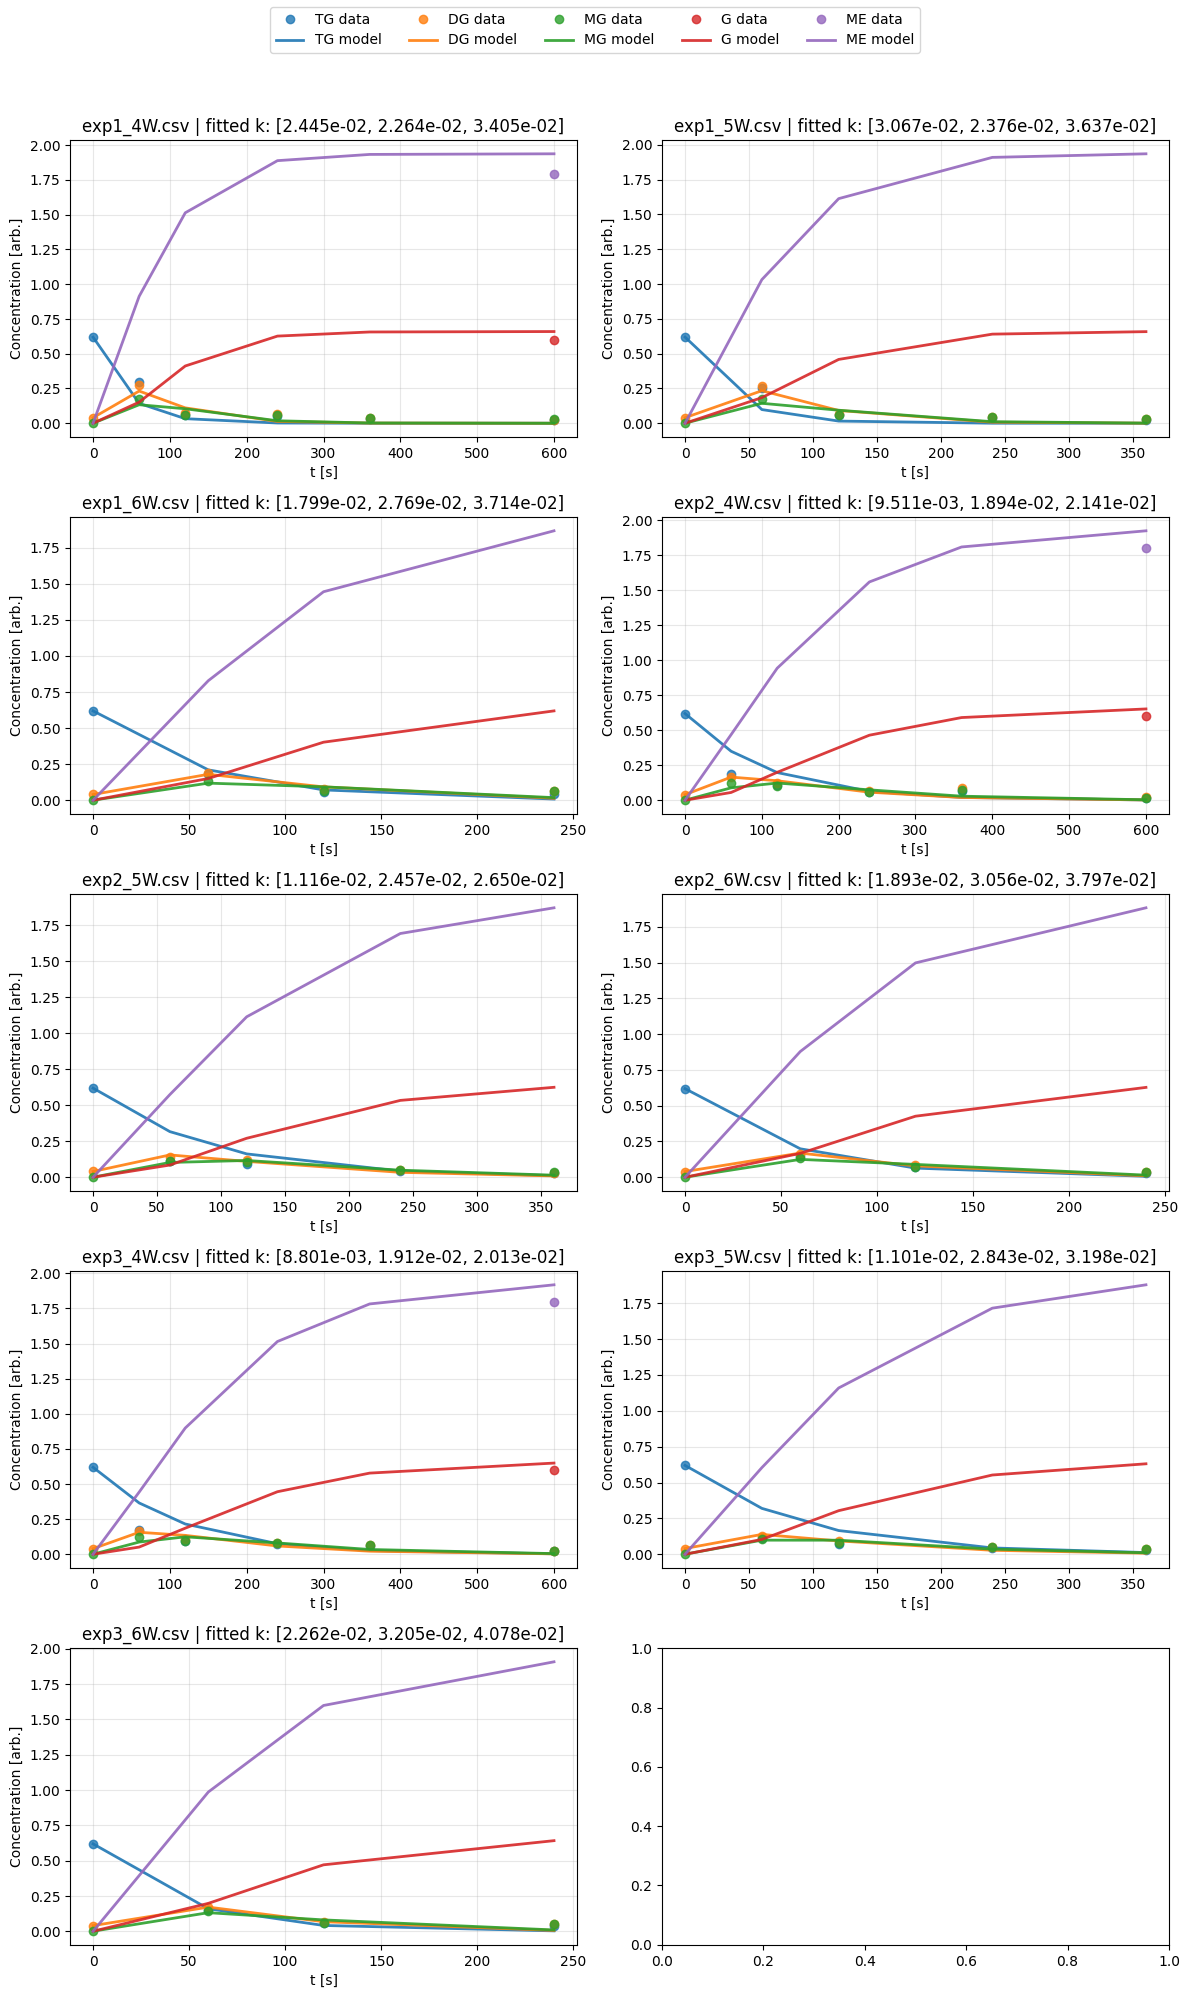


Fit summary:
exp1_4W.csv           k1=2.4447e-02  k2=2.2635e-02  k3=3.4047e-02  cost=2.169e-01  success=True
exp1_5W.csv           k1=3.0672e-02  k2=2.3764e-02  k3=3.6367e-02  cost=1.338e-01  success=True
exp1_6W.csv           k1=1.7985e-02  k2=2.7690e-02  k3=3.7138e-02  cost=1.205e-01  success=True
exp2_4W.csv           k1=9.5114e-03  k2=1.8944e-02  k3=2.1412e-02  cost=2.645e-01  success=True
exp2_5W.csv           k1=1.1164e-02  k2=2.4569e-02  k3=2.6503e-02  cost=1.127e-01  success=True
exp2_6W.csv           k1=1.8930e-02  k2=3.0559e-02  k3=3.7974e-02  cost=4.551e-02  success=True
exp3_4W.csv           k1=8.8008e-03  k2=1.9117e-02  k3=2.0130e-02  cost=2.586e-01  success=True
exp3_5W.csv           k1=1.1012e-02  k2=2.8431e-02  k3=3.1982e-02  cost=1.568e-01  success=True
exp3_6W.csv           k1=2.2620e-02  k2=3.2049e-02  k3=4.0782e-02  cost=9.203e-02  success=True


In [ ]:
# TG -> DG -> MG -> G with 1 ME formed per step (total 3 per TG)
# IMPORTANT GUYS: expects data in /content/bio-pinn/Data

import os
import re
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

DATA_DIR = "/content/bio-pinn/Data"  # get data

# species order used in the model and arrays
SPECIES = ["TG", "DG", "MG", "G", "ME"]

@dataclass
class ExpData:
    name: str
    t: np.ndarray            # time [s]
    Y: np.ndarray            # shape (len(SPECIES), len(t)) - nan if smth missing
    y0: np.ndarray           # initial condition (len(SPECIES),)
    present_mask: np.ndarray # shape (len(SPECIES),) True if column exists in csv


def read_experiment_csv(path: str) -> ExpData:
    df = pd.read_csv(path)
    # normalize column names (strip spaces, uppercase/lowercase consistent)
    df.columns = [c.strip() for c in df.columns]
    # expected columns: t,TG,DG,MG,G,ME (some may be missing/empty in early times)
    if "t" not in df.columns:
        raise ValueError(f"Column 't' is missing in {path}")
    # ensure all species columns exist --> create missing with NaN
    for s in SPECIES:
        if s not in df.columns:
            df[s] = np.nan

    # convert to numeric, coerce errors to NaN, then fill remaining NaN with 0 later
    for s in ["t"] + SPECIES:
        df[s] = pd.to_numeric(df[s], errors="coerce")

    # sort by time, drop duplicate times if any
    df = df.sort_values("t").drop_duplicates(subset=["t"])
    t = df["t"].to_numpy(dtype=float)

    # build matrix Y with species rows
    Y = np.vstack([df[s].to_numpy(dtype=float) for s in SPECIES])
    present_mask = np.array([not df[s].isna().all() for s in SPECIES], dtype=bool)

    # initial condition from first time row; NaN -> 0
    y0 = Y[:, 0].copy()
    y0 = np.where(np.isnan(y0), 0.0, y0)

    # replace null in the full series with 0 only for plotting residuals
    # keep a copy with null to mask residuals per species/time
    name = os.path.basename(path)
    return ExpData(name=name, t=t, Y=Y, y0=y0, present_mask=present_mask)


def biodiesel_chain_ode(t: float, y: np.ndarray, k1: float, k2: float, k3: float) -> np.ndarray:
    """
    TG -> DG -> MG -> G
    Each step forms 1 ME. Pseudo-first order in each glyceride (methanol in excess).
    y = [TG, DG, MG, G, ME]
    """
    TG, DG, MG, G, ME = y
    r1 = k1 * TG
    r2 = k2 * DG
    r3 = k3 * MG
    dTG = -r1
    dDG = r1 - r2
    dMG = r2 - r3
    dG  = r3
    dME = r1 + r2 + r3
    return np.array([dTG, dDG, dMG, dG, dME], dtype=float)


def simulate_times(t: np.ndarray, y0: np.ndarray, k: np.ndarray) -> np.ndarray:
    """Integrate the ODE at specified times t, return Y (species x time)."""
    k1, k2, k3 = float(k[0]), float(k[1]), float(k[2])
    # solve_ivp expects t_span=(t0, tf) and evaluation times t_eval
    sol = solve_ivp(
        fun=lambda tt, yy: biodiesel_chain_ode(tt, yy, k1, k2, k3),
        t_span=(float(t[0]), float(t[-1])),
        y0=y0.astype(float),
        t_eval=t.astype(float),
        method="LSODA",  # stiffness handling
        atol=1e-9,
        rtol=1e-7,
        vectorized=False,
        max_step=np.inf
    )
    if not sol.success:
        raise RuntimeError(f"ODE solver failed: {sol.message}")
    # sol.y shape: (n_species, n_times)
    return sol.y


def residuals_for_fit(k: np.ndarray, exp: ExpData, weights: np.ndarray) -> np.ndarray:
    """
    Build residual vector stacking species/time where data is present (non-NaN).
    weights is an array (len(SPECIES),) to balance species scale.
    """
    Yhat = simulate_times(exp.t, exp.y0, k)  # species x time
    # !!! only compare where exp.Y is not NaN
    mask = ~np.isnan(exp.Y)
    res = (Yhat - np.where(mask, exp.Y, Yhat))  # difference only where data exists
    # zero out residuals where data missing
    res = np.where(mask, res, 0.0)
    # apply species weights
    res = res * weights[:, None]
    return res.ravel()


def fit_k_for_experiment(exp: ExpData) -> Tuple[np.ndarray, Dict]:
    """
    Fit k1,k2,k3 >= 0 for one experiment by least squares.
    Returns (k_opt, info_dict).
    """
    # scale weights per species to balance magnitude (use 1 / (max observed + eps))
    max_per_species = np.nanmax(exp.Y, axis=1)
    weights = 1.0 / (np.where(np.isfinite(max_per_species) & (max_per_species > 0), max_per_species, 1.0))

    # initial guess-> estimate k1 from initial TG slope if at least two points are present
    def estimate_k_from_series(series: np.ndarray, t: np.ndarray) -> float:
        # If at least 2 finite points, use finite diff of first segment
        finite = np.isfinite(series)
        idx = np.where(finite)[0]
        if len(idx) >= 2:
            i0, i1 = idx[0], idx[1]
            dt = max(t[i1] - t[i0], 1e-9)
            s0, s1 = series[i0], series[i1]
            # for a first-order decay x' = -k x, approx k ~ (x0 - x1) / (x0 * dt) if x0>0
            if s0 > 0 and (s0 - s1) > 0:
                return min(max((s0 - s1) / (s0 * dt), 1e-6), 10.0)
        return 1e-3

    # build extended series using measured Y & simulated fallback for estimation
    TG_series = exp.Y[0, :]
    DG_series = exp.Y[1, :]
    MG_series = exp.Y[2, :]

    k0 = np.array([
        estimate_k_from_series(TG_series, exp.t),
        estimate_k_from_series(DG_series, exp.t),
        estimate_k_from_series(MG_series, exp.t)
    ], dtype=float)

    bounds = (np.array([0.0, 0.0, 0.0]), np.array([10.0, 10.0, 10.0]))  # broad but positive

    res = least_squares(
        fun=lambda kk: residuals_for_fit(kk, exp, weights),
        x0=k0,
        bounds=bounds,
        verbose=0,
        ftol=1e-10,
        xtol=1e-10,
        gtol=1e-10,
        max_nfev=300
    )
    info = {
        "success": res.success,
        "message": res.message,
        "cost": res.cost,
        "nfev": res.nfev,
        "initial_k": k0
    }
    return res.x, info


def load_all_experiments(data_dir: str) -> List[ExpData]:
    # match files
    paths = sorted(glob.glob(os.path.join(data_dir, "exp*_*.csv")))
    if not paths:
        raise FileNotFoundError(f"No exp*.csv files found in {data_dir}")
    exps = []
    for p in paths:
        try:
            exps.append(read_experiment_csv(p))
        except Exception as e:
            print(f"Skipping {p} due to error: {e}")
    if not exps:
        raise RuntimeError("No experiments could be loaded.")
    print("Loaded experiments:")
    for e in exps:
        print(f" - {e.name} (n={len(e.t)} points, columns present: {', '.join(np.array(SPECIES)[e.present_mask])})")
    return exps


def power_from_name(name: str) -> str:
    # Extract "4W"/"5W"/"6W" as a label if present
    m = re.search(r"_(\d)W", name)
    return f"{m.group(1)}W" if m else ""


def main():
    exps = load_all_experiments(DATA_DIR)

    results = []
    ncols = 2
    nrows = int(np.ceil(len(exps) / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows), sharex=False, sharey=False)
    if nrows * ncols == 1:
        axes = np.array([[axes]])
    axes = axes.reshape(nrows, ncols)

    for idx, exp in enumerate(exps):
        k_opt, info = fit_k_for_experiment(exp)
        Yhat = simulate_times(exp.t, exp.y0, k_opt)
        results.append((exp, k_opt, info, Yhat))

        ax = axes[idx // ncols, idx % ncols]
        ax.set_title(f"{exp.name} | fitted k: [{k_opt[0]:.3e}, {k_opt[1]:.3e}, {k_opt[2]:.3e}]")
        colors = {"TG": "C0", "DG": "C1", "MG": "C2", "G": "C3", "ME": "C4"}
        # Plot measurements points
        for si, s in enumerate(SPECIES):
            y_meas = exp.Y[si, :]
            mask = np.isfinite(y_meas)
            if mask.any():
                ax.plot(exp.t[mask], y_meas[mask], "o", color=colors[s], label=f"{s} data" if idx == 0 else None, alpha=0.8)
            # plot model, line
            ax.plot(exp.t, Yhat[si, :], "-", color=colors[s], label=f"{s} model" if idx == 0 else None, linewidth=2, alpha=0.9)

        ax.set_xlabel("t [s]")
        ax.set_ylabel("Concentration [arb.]")
        ax.grid(True, alpha=0.3)

    # Legend only once
    handles, labels = axes[0,0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper center", ncol=5)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print summary
    print("\nFit summary:")
    for exp, k_opt, info, _ in results:
        print(f"{exp.name:20s}  k1={k_opt[0]:.4e}  k2={k_opt[1]:.4e}  k3={k_opt[2]:.4e}  cost={info['cost']:.3e}  success={info['success']}")

if __name__ == "__main__":
    main()

9 Datensätze gefunden: ['exp1_4W', 'exp1_5W', 'exp1_6W', 'exp2_4W', 'exp2_5W', 'exp2_6W', 'exp3_4W', 'exp3_5W', 'exp3_6W']


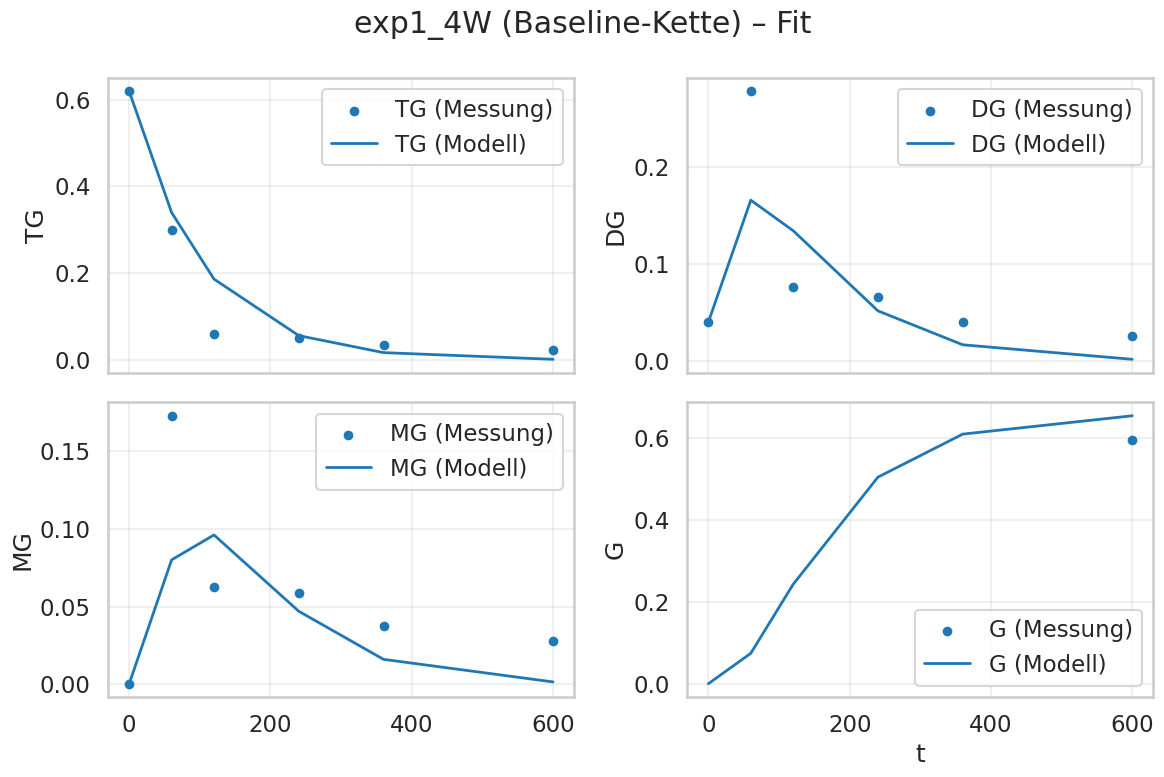

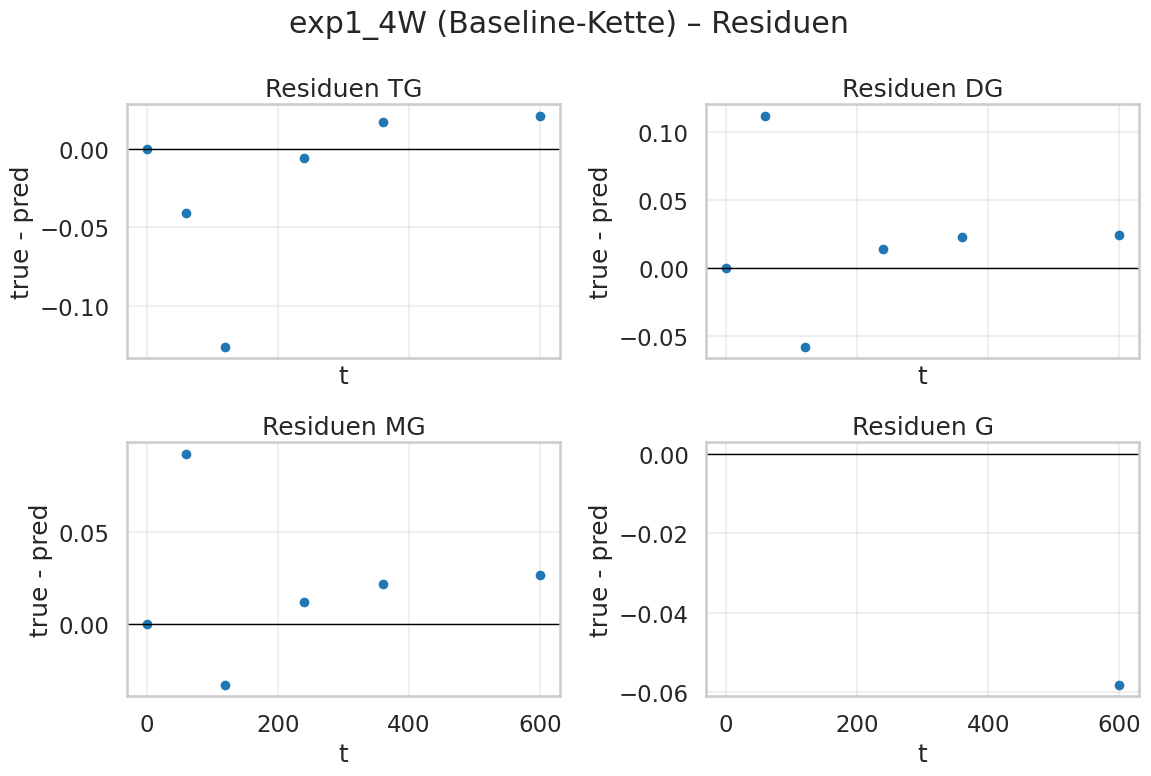

Massenbilanz (TG+DG+MG+G): RMSE=0.3549, max|Fehler|=0.5484
Informationskriterien: AIC=-106.90, BIC=-104.07
Metriken:
TG: n=6, MAE=0.03513, RMSE=0.05525, NRMSE=0.09257, R²=0.9356
DG: n=6, MAE=0.03851, RMSE=0.05354, NRMSE=0.2128, R²=0.6179
MG: n=6, MAE=0.03094, RMSE=0.04283, NRMSE=0.2483, R²=0.3831
G: n=1, MAE=0.05814, RMSE=0.05814, NRMSE=0.09742, R²=nan


In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, Callable, Tuple, Optional
from scipy.integrate import solve_ivp

DATA_DIR = "/content/bio-pinn/Data"

# load data
def load_experiments(data_dir: str = DATA_DIR) -> Dict[str, pd.DataFrame]:
    files = sorted(glob.glob(os.path.join(data_dir, "exp*_*.csv")))
    exps = {}
    for f in files:
        name = os.path.splitext(os.path.basename(f))[0]
        df = pd.read_csv(f)
        expected = ["t","TG","DG","MG","G","ME"]
        for c in expected:
            if c not in df.columns:
                df[c] = np.nan
        df = df.sort_values("t").drop_duplicates(subset="t")
        exps[name] = df.reset_index(drop=True)
    return exps

exps = load_experiments()
print(f"{len(exps)} Datensätze gefunden:", list(exps.keys()))

@dataclass
class Metrics:
    species: str
    n: int
    MAE: float
    RMSE: float
    NRMSE: float
    R2: float

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray, species: str) -> Optional[Metrics]:
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        return None
    y_t = y_true[mask]
    y_p = y_pred[mask]
    err = y_t - y_p
    mae = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    denom = np.ptp(y_t) if np.ptp(y_t) > 0 else (np.max(np.abs(y_t)) + 1e-12)
    nrmse = rmse / (denom + 1e-12)
    sst = np.sum((y_t - np.mean(y_t))**2)
    r2 = 1.0 - np.sum(err**2)/sst if sst > 0 else np.nan
    return Metrics(species, mask.sum(), mae, rmse, nrmse, r2)

def plot_fit(df: pd.DataFrame, preds: pd.DataFrame, title: str):
    species_list = ["TG","DG","MG","G"]
    fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
    axes = axes.ravel()
    for i, sp in enumerate(species_list):
        if sp not in df.columns: continue
        ax = axes[i]
        ax.scatter(df["t"], df[sp], s=30, label=f"{sp} (Messung)")
        if sp in preds.columns:
            ax.plot(preds["t"], preds[sp], lw=2, label=f"{sp} (Modell)")
        ax.set_ylabel(sp)
        ax.grid(True, alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel("t")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_residuals(df: pd.DataFrame, preds: pd.DataFrame, title: str):
    species_list = ["TG","DG","MG","G"]
    fig, axes = plt.subplots(2, 2, figsize=(12,8), sharex=True)
    axes = axes.ravel()
    for i, sp in enumerate(species_list):
        ax = axes[i]
        if sp in df.columns and sp in preds.columns:
            # match by time
            merged = pd.merge(df[["t",sp]], preds[["t",sp]], on="t", how="inner", suffixes=("_true","_pred"))
            resid = merged[f"{sp}_true"] - merged[f"{sp}_pred"]
            ax.axhline(0, color="k", lw=1)
            ax.scatter(merged["t"], resid, s=30)
            ax.set_title(f"Residuen {sp}")
            ax.set_xlabel("t")
            ax.set_ylabel("true - pred")
            ax.grid(True, alpha=0.3)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def mass_balance_check(df: pd.DataFrame, preds: pd.DataFrame, species=("TG","DG","MG","G")) -> Tuple[float, float]:
    cols = [c for c in species if c in df.columns]
    m_true = df[["t"]].copy()
    m_pred = preds[["t"]].copy()
    m_true["sum"] = df[cols].sum(axis=1, skipna=True)
    m_pred["sum"] = preds[cols].sum(axis=1, skipna=True)
    merged = pd.merge(m_true, m_pred, on="t", suffixes=("_true","_pred"))
    diff = merged["sum_true"] - merged["sum_pred"]
    rmse = float(np.sqrt(np.mean(diff**2))) if len(diff) else np.nan
    max_abs = float(np.max(np.abs(diff))) if len(diff) else np.nan
    return rmse, max_abs

def information_criteria(all_residuals: np.ndarray, k_params: int) -> Tuple[float, float]:
    n = len(all_residuals)
    if n == 0:
        return np.nan, np.nan
    sse = float(np.sum(all_residuals**2))
    sigma2 = sse / n
    aic = n*np.log(sigma2 + 1e-32) + 2*k_params
    bic = n*np.log(sigma2 + 1e-32) + k_params*np.log(n)
    return aic, bic

def evaluate_experiment(df: pd.DataFrame,
                        simulate_fn: Callable[[np.ndarray, np.ndarray, dict], pd.DataFrame],
                        params: np.ndarray,
                        sim_cfg: dict,
                        k_params: int,
                        title: str = "") -> Dict[str, Metrics]:

    t_eval = df["t"].values.astype(float)
    if sim_cfg.get("y0_from_data", True):
        df0 = df[df["t"] == df["t"].min()].iloc[0]
        y0 = {sp: float(df0.get(sp, np.nan)) for sp in ["TG","DG","MG","G"]}
        for sp in y0:
            if not np.isfinite(y0[sp]): y0[sp] = 0.0
        sim_cfg = {**sim_cfg, "y0": y0}

    preds = simulate_fn(params, t_eval, sim_cfg).copy()
    results = {}
    all_resid = []
    for sp in ["TG","DG","MG","G"]:
        if sp in df.columns and sp in preds.columns:
            m = compute_metrics(df[sp].values, preds[sp].values, sp)
            if m:
                results[sp] = m
                # get residuals
                mask = np.isfinite(df[sp].values) & np.isfinite(preds[sp].values)
                all_resid.append((df[sp].values - preds[sp].values)[mask])

    if len(all_resid):
        all_resid = np.concatenate(all_resid)
        aic, bic = information_criteria(all_resid, k_params=k_params)
    else:
        aic = bic = np.nan

    # Plots
    if title:
        plot_fit(df, preds, title=title + " – Fit")
        plot_residuals(df, preds, title=title + " – Residuen")
        mb_rmse, mb_max = mass_balance_check(df, preds)
        print(f"Massenbilanz (TG+DG+MG+G): RMSE={mb_rmse:.4g}, max|Fehler|={mb_max:.4g}")
        print(f"Informationskriterien: AIC={aic:.2f}, BIC={bic:.2f}")

    return results

def _chain_rhs(t, y, k1, k2, k3):
    TG, DG, MG, G = y
    dTG = -k1*TG
    dDG = k1*TG - k2*DG
    dMG = k2*DG - k3*MG
    dG  = k3*MG
    return [dTG, dDG, dMG, dG]

def simulate_chain(params: np.ndarray, t_eval: np.ndarray, cfg: dict) -> pd.DataFrame:
    k1, k2, k3 = params  # 3 Parameter
    y0_map = cfg.get("y0", {"TG":0,"DG":0,"MG":0,"G":0})
    y0 = [y0_map.get(sp, 0.0) for sp in ["TG","DG","MG","G"]]
    t0, tf = float(np.min(t_eval)), float(np.max(t_eval))
    sol = solve_ivp(lambda t,y: _chain_rhs(t,y,k1,k2,k3),
                    (t0, tf), y0, t_eval=np.asarray(t_eval), method="LSODA", rtol=1e-8, atol=1e-10)
    out = pd.DataFrame({"t": sol.t,
                        "TG": sol.y[0], "DG": sol.y[1], "MG": sol.y[2], "G": sol.y[3]})
    return out

exp_name = "exp1_4W"
if exp_name in exps:
    df_exp = exps[exp_name].copy()
    params_demo = np.array([0.01, 0.02, 0.03])  # k1,k2,k3
    metrics = evaluate_experiment(df_exp, simulate_chain, params_demo,
                                  sim_cfg={"y0_from_data": True},
                                  k_params=len(params_demo),
                                  title=f"{exp_name} (Baseline-Kette)")
    print("Metriken:")
    for sp, m in metrics.items():
        print(f"{sp}: n={m.n}, MAE={m.MAE:.4g}, RMSE={m.RMSE:.4g}, NRMSE={m.NRMSE:.4g}, R²={m.R2:.4f}")
else:
    print(f"{exp_name} nicht gefunden. Verfügbare: {list(exps.keys())}")
